Instructions for updating:
non-resource variables are not supported in the long term
episode: 0 loss: 7.951594e-06
episode: 1 loss: 5.3254325e-06
episode: 2 loss: 2.729785e-06
episode: 3 loss: 9.920278e-06
episode: 4 loss: 3.6971876e-06
episode: 5 loss: 4.368111e-06
episode: 6 loss: 4.4569097e-06
episode: 7 loss: 5.8181954e-06
episode: 8 loss: 3.175673e-06
episode: 9 loss: 5.97635e-06
episode: 10 loss: 4.58691e-06
episode: 11 loss: 5.525238e-06
episode: 12 loss: 3.86185e-06
episode: 13 loss: 5.413116e-06
episode: 14 loss: 3.1568486e-06
episode: 15 loss: 2.23853e-06
episode: 16 loss: 2.7881542e-06
episode: 17 loss: 3.0879507e-06
episode: 18 loss: 2.2335785e-06
episode: 19 loss: 3.070187e-06
episode: 20 loss: 2.7149254e-06
episode: 21 loss: 2.6332498e-06
episode: 22 loss: 3.2945397e-06
episode: 23 loss: 6.2369963e-07
episode: 24 loss: 0.011780552
episode: 25 loss: 2.3948407e-06
episode: 26 loss: 1.6175392e-06
episode: 27 loss: 1.8954888e-06
episode: 28 loss: 2.6246446e-06
episode: 29 los

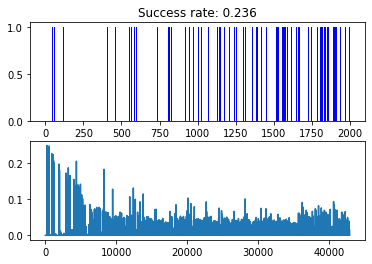

In [1]:
import gym
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
from gym.envs.registration import register
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def one_hot(x):
    return np.identity(16)[x:x+1]

register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': True}
)
env = gym.make('FrozenLake-v3')

input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1
lr_stochastic = .85

x = tf.placeholder(tf.float32, [1, input_size])
w = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))

Qpred = tf.matmul(x, w)
y = tf.placeholder(tf.float32, [1, output_size])

loss = tf.reduce_mean(tf.square(y-Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

dis = .99
num_episodes = 2000

rList =[]

sess = tf.Session()
sess.run(tf.global_variables_initializer())
global_loss= []
for i in range(num_episodes):
    state = env.reset()
    e = 1. / ((i/100) + 1)
    rAll = 0
    done = False
    local_loss = []

    while not done:
        Qs = sess.run(Qpred, feed_dict={x: one_hot(state)})
        if np.random.rand(1)<e:
            action = env.action_space.sample()
        else:
            action = np.argmax(Qs)

        new_state , reward, done, _ = env.step(action)
        if done:
            Qs[0, action] = reward
        else:
            Qs1 = sess.run(Qpred, feed_dict={x: one_hot(new_state)})
            Qs[0, action] = reward + dis * np.max(Qs1)
        l,_ = sess.run([loss, train], feed_dict={x: one_hot(state), y: Qs})
        global_loss.append(l)
        local_loss.append(l)
        rAll +=reward
        state = new_state
    print('episode:', i, 'loss:', np.mean(local_loss))
    rList.append(rAll)

print('Success rate : '+str(sum(rList)/num_episodes))
ax1 = plt.subplot(212)
ax1.plot(global_loss)
ax = plt.subplot(211)
ax.title.set_text("Success rate: " + str(sum(rList) / num_episodes))
ax.bar(range(len(rList)), rList, color='blue')
plt.show()